In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import helpers_dev

df = pd.read_csv('continuous_factory_process.csv')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# FEATURE ENGINEERING

This notebook turns the noisy 1 Hz factory time series into structured features for modeling (XGBoost/ensembles).

Plan for feature engineering (high level):

1. **Sensor / data quality features**
   - Binary indicator for global sensor reset window (`sensor_reset`).

2. **Raw material properties (Stage 1, Machines 1–3)**
   - Normalize 12 raw material properties (scale differences are huge).
   - Machine-level change signals: any-change flags, time-since-change, recent change counts.

3. **Process variables (Stage 1 & combiner)**
   - Rolling statistics (mean/std/min/max) over multiple windows.

4. **Targets & label engineering**
   - Decide whether to predict Actuals, Setpoint error, or both for the 15 primary outputs.

In [2]:
# Sensor reset period: 2019-03-06 11:54:27 to 2019-03-06 12:03:10
reset_start = pd.to_datetime('2019-03-06 11:54:27')
reset_end = pd.to_datetime('2019-03-06 12:03:10')

# Create binary indicator for sensor reset period
df['sensor_reset'] = ((df['time_stamp'] >= reset_start) & (df['time_stamp'] <= reset_end)).astype(int)

/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_3541/1351479720.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sensor_reset'] = ((df['time_stamp'] >= reset_start) & (df['time_stamp'] <= reset_end)).astype(int)


In [3]:
# Feature Engineering: Raw Material Properties
# Get raw material columns for each machine
m1_raw_cols = df.columns[3:7].tolist()  # Machine 1: columns 3-6
m2_raw_cols = df.columns[15:19].tolist()  # Machine 2: columns 15-18
m3_raw_cols = df.columns[27:31].tolist()  # Machine 3: columns 27-30

# Store all raw material columns for feature engineering
all_raw_cols = m1_raw_cols + m2_raw_cols + m3_raw_cols
# Create features for each raw material property

# Store feature names for tracking
raw_material_features = []
new_features_dict = {}

for col in all_raw_cols:
    # 1. Binary change indicator
    change_col = f'{col}_changed'
    new_features_dict[change_col] = (df[col] != df[col].shift(1)).astype(int)
    raw_material_features.append(change_col)
    
    # 2. Normalized change magnitude (using std for normalization)
    # Change = current - previous, normalized by property's std
    prop_std = df[col].std()
    if prop_std > 0:
        change_mag_col = f'{col}_change_magnitude'
        change_mag = (df[col] - df[col].shift(1)) / prop_std
        new_features_dict[change_mag_col] = change_mag.fillna(0)  # First row has no previous value
        raw_material_features.append(change_mag_col)
    
    # 3. Time since last change (in seconds, since 1 Hz sampling)
    time_since_col = f'{col}_time_since_change'
    # Create a series that increments until a change occurs, then resets
    change_series = new_features_dict[change_col]
    change_indices = change_series[change_series == 1].index
    time_since = np.zeros(len(df))
    last_change_idx = -1
    for i in range(len(df)):
        if i in change_indices.values:
            last_change_idx = i
        if last_change_idx >= 0:
            time_since[i] = i - last_change_idx
    new_features_dict[time_since_col] = pd.Series(time_since, index=df.index)
    raw_material_features.append(time_since_col)

# Concatenate all new features at once to avoid fragmentation
new_features_df = pd.DataFrame(new_features_dict, index=df.index)
df = pd.concat([df, new_features_df], axis=1)

print(f"Created {len(raw_material_features)} individual raw material features")
print(f"Sample features: {raw_material_features[:6]}")

Created 36 individual raw material features
Sample features: ['Machine1.RawMaterial.Property1_changed', 'Machine1.RawMaterial.Property1_change_magnitude', 'Machine1.RawMaterial.Property1_time_since_change', 'Machine1.RawMaterial.Property2_changed', 'Machine1.RawMaterial.Property2_change_magnitude', 'Machine1.RawMaterial.Property2_time_since_change']


In [4]:
# Create aggregated features per machine
# For each machine, create combined features
machine_raw_cols = {
    'M1': m1_raw_cols,
    'M2': m2_raw_cols,
    'M3': m3_raw_cols
}

aggregated_features_dict = {}

for machine, cols in machine_raw_cols.items():
    # Get change indicator columns for this machine
    change_cols = [f'{col}_changed' for col in cols]
    
    # 1. Total number of properties that changed at time t
    total_changes_col = f'{machine}_raw_total_changes'
    aggregated_features_dict[total_changes_col] = df[change_cols].sum(axis=1)
    raw_material_features.append(total_changes_col)
    
    # 2. Binary: Did any property change?
    any_change_col = f'{machine}_raw_any_change'
    aggregated_features_dict[any_change_col] = (aggregated_features_dict[total_changes_col] > 0).astype(int)
    raw_material_features.append(any_change_col)
    
    # 3. Time since any property changed (minimum time since change across all properties)
    time_since_cols = [f'{col}_time_since_change' for col in cols]
    min_time_col = f'{machine}_raw_min_time_since_change'
    aggregated_features_dict[min_time_col] = df[time_since_cols].min(axis=1)
    raw_material_features.append(min_time_col)
    
    # 4. Count of changes in rolling windows (5, 10, 30 minutes)
    for window_min in [5, 10, 30]:
        window_sec = window_min * 60  # Convert to seconds (1 Hz sampling)
        changes_count_col = f'{machine}_raw_changes_last_{window_min}min'
        aggregated_features_dict[changes_count_col] = aggregated_features_dict[total_changes_col].rolling(window=window_sec, min_periods=1).sum()
        raw_material_features.append(changes_count_col)

# Concatenate aggregated features at once
aggregated_features_df = pd.DataFrame(aggregated_features_dict, index=df.index)
df = pd.concat([df, aggregated_features_df], axis=1)

print(f"\nTotal raw material features created: {len(raw_material_features)}")

# Rare Changes -> normalize and keep larger changes in magnitude
useful_raw_features = []

for machine in ['M1', 'M2', 'M3']:
    # Keep these aggregated features
    useful_raw_features.extend([
        f'{machine}_raw_any_change',  # Binary: did any property change?
        f'{machine}_raw_min_time_since_change',  # Time since last change
        f'{machine}_raw_changes_last_5min',  # Recent change activity
        f'{machine}_raw_changes_last_10min',
        f'{machine}_raw_changes_last_30min'
    ])

scaler = StandardScaler()
normalized_raw_features = []

for col in all_raw_cols:
    normalized_col = f'{col}_normalized'
    df[normalized_col] = scaler.fit_transform(df[[col]])
    normalized_raw_features.append(normalized_col)

final_raw_features = useful_raw_features + normalized_raw_features
print(f"Final raw material features: {len(final_raw_features)}")
print(f"Final normalized raw material features: {len(normalized_raw_features)}")


Total raw material features created: 54
Final raw material features: 27
Final normalized raw material features: 12


/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_3541/749867483.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[normalized_col] = scaler.fit_transform(df[[col]])
/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_3541/749867483.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[normalized_col] = scaler.fit_transform(df[[col]])
/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_3541/749867483.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

## Feature Informativeness Diagnostic

Quick assessment of how informative engineered features are for output prediction using:
1. **Correlation analysis** - Linear relationships
2. **Mutual information** - Non-linear relationships

CORRELATION ANALYSIS (Linear Relationships)

Top 15 features by absolute correlation:
                                  Feature  Correlation  Abs_Correlation
                             sensor_reset    -0.311850         0.311850
                M2_raw_changes_last_30min    -0.165756         0.165756
Machine3.RawMaterial.Property4_normalized     0.114379         0.114379
Machine3.RawMaterial.Property2_normalized     0.106036         0.106036
                M3_raw_changes_last_10min    -0.092120         0.092120
             M2_raw_min_time_since_change     0.088941         0.088941
Machine3.RawMaterial.Property3_normalized     0.059736         0.059736
Machine1.RawMaterial.Property1_normalized     0.055585         0.055585
             M1_raw_min_time_since_change    -0.053505         0.053505
Machine2.RawMaterial.Property2_normalized     0.052805         0.052805
Machine2.RawMaterial.Property1_normalized     0.052805         0.052805
Machine2.RawMaterial.Property3_normalized    -0.05

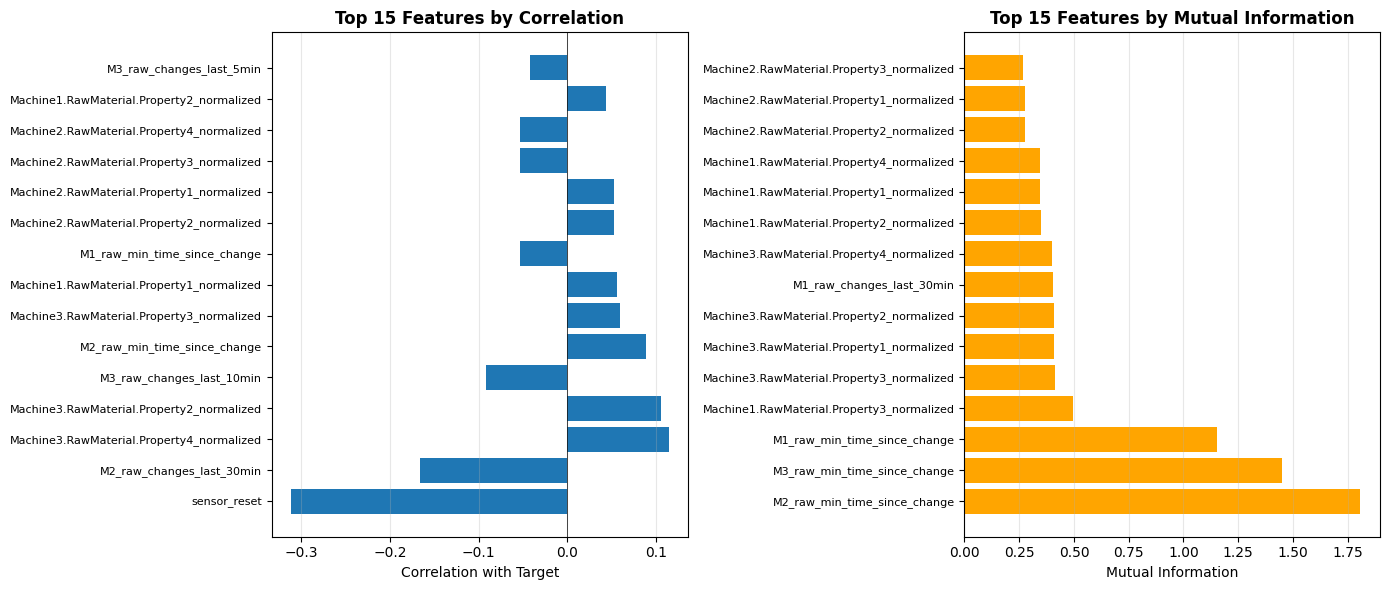

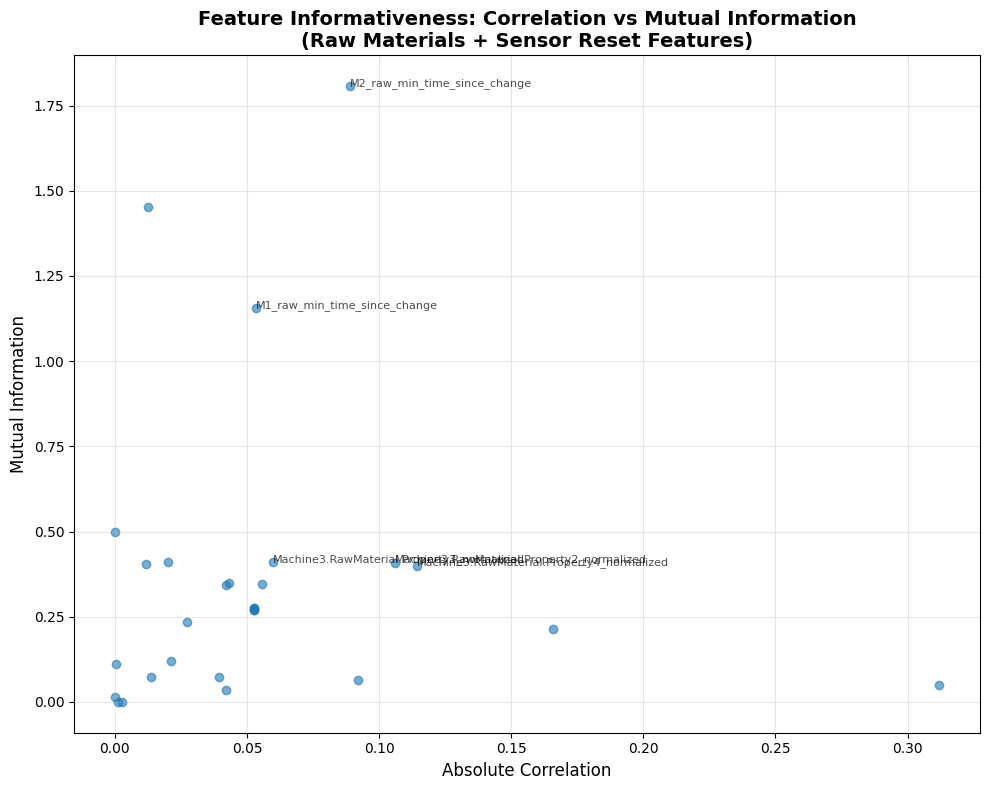

In [5]:
target_col = 'Stage1.Output.Measurement0.U.Actual'

# Get feature columns for raw materials + sensor reset
feature_cols = final_raw_features + ['sensor_reset']

# Prepare data
X = df[feature_cols]
y = df[target_col]

# Run feature informativeness analysis using helper function
raw_materials_results = helpers_dev.analyze_feature_informativeness(
    X=X,
    y=y,
    feature_names=feature_cols,
    target_name="Raw Materials + Sensor Reset Features",
    top_n=15,
    plot=True
)

In [6]:
# Access results from helper function
corr_df = raw_materials_results['correlation_df']
mi_df = raw_materials_results['mi_df']
combined_df = raw_materials_results['combined_df']
summary = raw_materials_results['summary']

### Interpretation

**Key Findings from Correlation & Mutual Information Analysis For Sensor Reset & Raw Materials Data:**

1. **Mutual Information reveals strong non-linear relationships:**
   - `M2_raw_min_time_since_change` (MI=1.78), `M3_raw_min_time_since_change` (MI=1.42), `M1_raw_min_time_since_change` (MI=1.13) are the most informative features
   - Normalized raw material properties have moderate MI (0.28-0.49)
   - **Conclusion**: Time since last material change is highly predictive, but relationships are **non-linear** 

2. **Correlation shows weak linear relationships:**
   - All correlations are weak (<0.2) except `sensor_reset` (-0.31, negative - resets cause output drops). This makes perfect sense.
   - Most features have correlations between -0.1 and 0.1. Linear Models will not work well!

**Implications:**
- Raw material features ARE informative (especially time-since-change features) - validates feature engineering
- Still need process variable features (rolling statistics) - raw materials provide context but process variables likely drive most variance

## PROCESS VARIABLES

In [7]:
m1_proc_cols = df.columns[7:15].tolist()  # Machine 1: columns 7-14
m2_proc_cols = df.columns[19:27].tolist()  # Machine 2: columns 19-26
m3_proc_cols = df.columns[31:39].tolist()  # Machine 3: columns 31-38
combiner_cols = df.columns[39:42].tolist()  # Combiner: columns 39-41

all_proc_cols = m1_proc_cols + m2_proc_cols + m3_proc_cols + combiner_cols

In [8]:
# Create rolling statistics for process variables
# Windows: 10s, 30s, 1min, 5min (since 1 Hz sampling, window = seconds)

rolling_windows = {
    '10s': 10,
    '30s': 30,
    '1min': 60,
    '5min': 300
}

rolling_stats = ['mean', 'std', 'min', 'max', 'median']

# Store all process features
process_features = []
process_features_dict = {}

for col in all_proc_cols:
    for window_name, window_size in rolling_windows.items():
        # Create rolling window
        rolling = df[col].rolling(window=window_size, min_periods=1)
        
        # Compute statistics
        for stat in rolling_stats:
            if stat == 'mean':
                feature_name = f'{col}_rolling_{window_name}_mean'
                process_features_dict[feature_name] = rolling.mean()
            elif stat == 'std':
                feature_name = f'{col}_rolling_{window_name}_std'
                process_features_dict[feature_name] = rolling.std().fillna(0)  # Fill NaN with 0 for std
            elif stat == 'min':
                feature_name = f'{col}_rolling_{window_name}_min'
                process_features_dict[feature_name] = rolling.min()
            elif stat == 'max':
                feature_name = f'{col}_rolling_{window_name}_max'
                process_features_dict[feature_name] = rolling.max()
            elif stat == 'median':
                feature_name = f'{col}_rolling_{window_name}_median'
                process_features_dict[feature_name] = rolling.median()
            
            process_features.append(feature_name)

# Concatenate all process features at once
process_features_df = pd.DataFrame(process_features_dict, index=df.index)
df = pd.concat([df, process_features_df], axis=1)

## Process Variable Feature Informativeness Analysis

Now analyze the informativeness of the 540 process variable rolling statistics features.

CORRELATION ANALYSIS (Linear Relationships)

Top 15 features by absolute correlation:
                                               Feature  Correlation  Abs_Correlation
   Machine2.Zone1Temperature.C.Actual_rolling_5min_min     0.247083         0.247083
   Machine2.Zone1Temperature.C.Actual_rolling_1min_min     0.189770         0.189770
 Machine2.MaterialTemperature.U.Actual_rolling_30s_std    -0.153148         0.153148
  Machine3.Zone2Temperature.C.Actual_rolling_5min_mean    -0.135154         0.135154
    Machine2.MaterialPressure.U.Actual_rolling_30s_max    -0.131266         0.131266
   Machine2.MaterialPressure.U.Actual_rolling_30s_mean    -0.129735         0.129735
 Machine2.MaterialPressure.U.Actual_rolling_30s_median    -0.129037         0.129037
   Machine2.MaterialPressure.U.Actual_rolling_5min_min    -0.128715         0.128715
   Machine2.MaterialPressure.U.Actual_rolling_1min_min    -0.128530         0.128530
  Machine2.MaterialPressure.U.Actual_rolling_1min_mean    -0.128

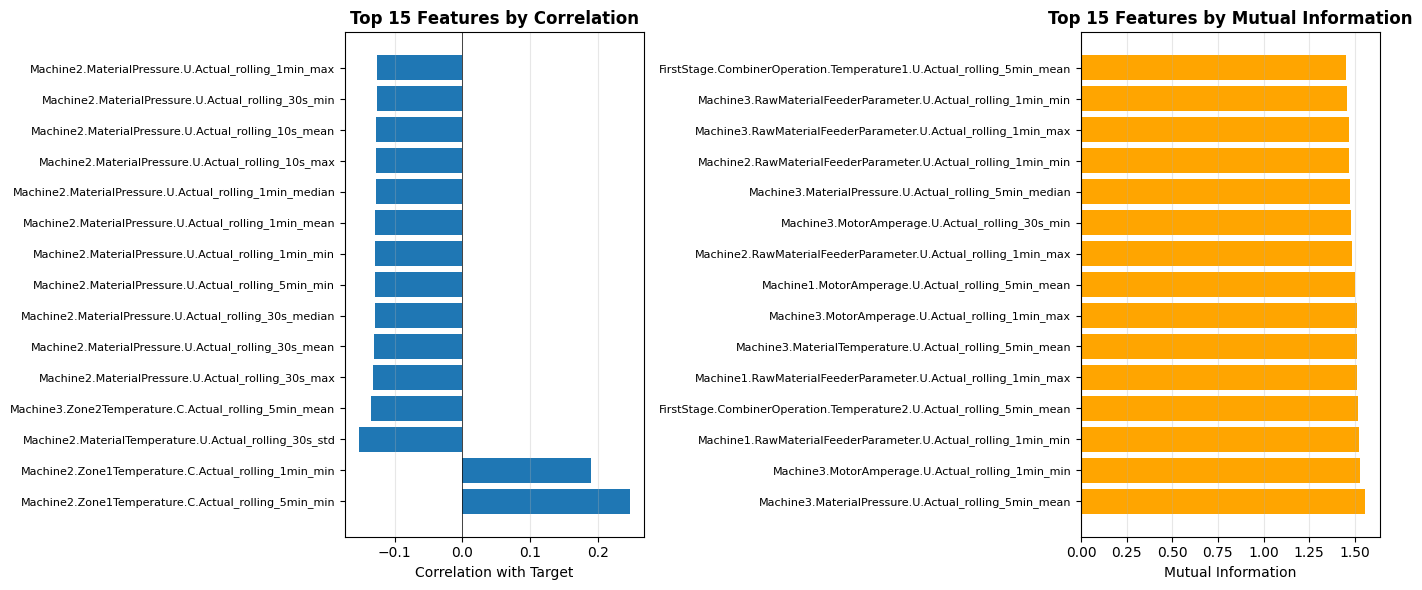

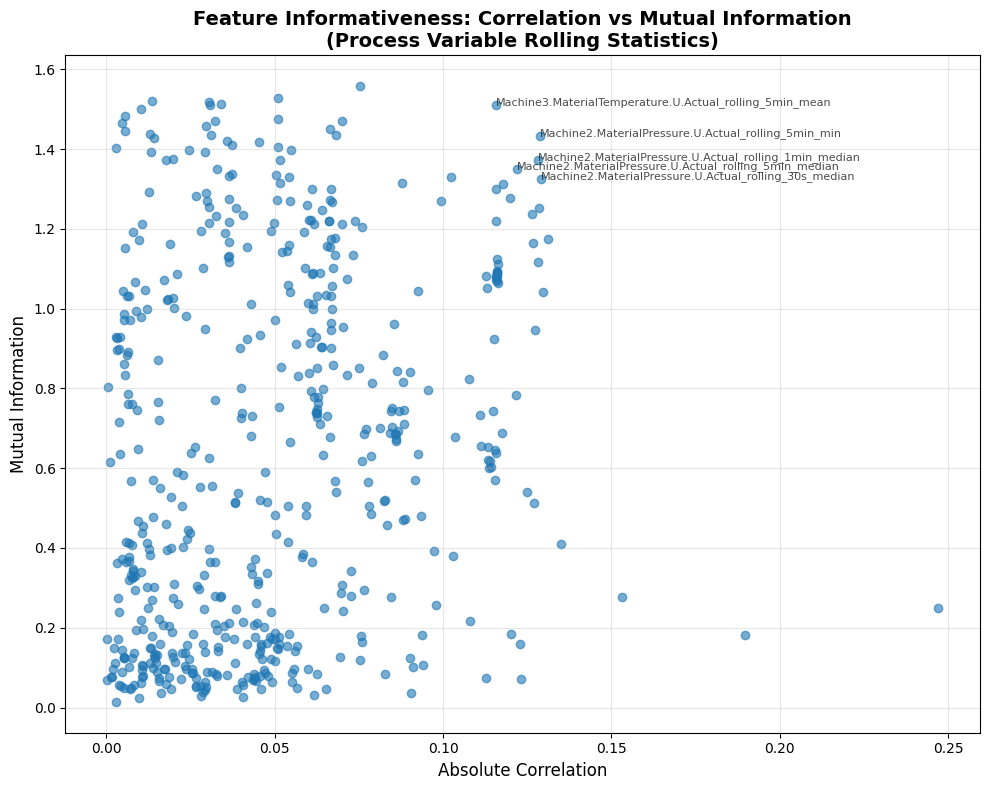

In [10]:
# Analyze process variable features
target_col = 'Stage1.Output.Measurement0.U.Actual'

# Get process variable feature columns
process_feature_cols = process_features

# Prepare data
X_process = df[process_feature_cols]
y_process = df[target_col]

# Run feature informativeness analysis using helper function
process_variables_results = helpers_dev.analyze_feature_informativeness(
    X=X_process,
    y=y_process,
    feature_names=process_feature_cols,
    target_name="Process Variable Rolling Statistics",
    top_n=15,
    plot=True
)

# MODEL DEVELOPMENT

Now that we have engineered 568 informative features, we'll build ensemble models to predict the 15 primary output measurements.

**Modeling Strategy:**
1. **Targets**: Predict all 15 `Stage1.Output.Measurement*.U.Actual` values
2. **Approach**: XGBoost/LightGBM (handles non-linear relationships well)
3. **Evaluation**: Time-based train/test split (preserve temporal order)
4. **Explainability**: Feature importance + SHAP values

In [18]:
# Prepare all features and targets
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
MODEL_LIB = 'xgboost'
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Combine all features
all_features = final_raw_features + process_features + ['sensor_reset']
print(f"Total features for modeling: {len(all_features)}")

# Get all 15 primary output targets
target_cols = [f'Stage1.Output.Measurement{i}.U.Actual' for i in range(15)]
print(f"Targets to predict: {len(target_cols)}")
print(f"Target columns: {target_cols[:3]}...{target_cols[-3:]}")

# Prepare feature matrix and target matrix
X = df[all_features].copy()
y_all = df[target_cols].copy()

# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in targets: {y_all.isnull().sum().sum()}")

# Remove rows where ALL targets are missing (sensor reset periods)
valid_mask = ~y_all.isnull().all(axis=1)
X = X[valid_mask].copy()
y_all = y_all[valid_mask].copy()

print(f"\nFinal data shape: {X.shape}")
print(f"Valid samples: {len(X)}")

Total features for modeling: 568
Targets to predict: 15
Target columns: ['Stage1.Output.Measurement0.U.Actual', 'Stage1.Output.Measurement1.U.Actual', 'Stage1.Output.Measurement2.U.Actual']...['Stage1.Output.Measurement12.U.Actual', 'Stage1.Output.Measurement13.U.Actual', 'Stage1.Output.Measurement14.U.Actual']

Missing values in features: 0
Missing values in targets: 0

Final data shape: (14088, 568)
Valid samples: 14088


In [17]:
# Time-based train/test split (preserve temporal order)
# Use first 70% for training, last 30% for testing
split_idx = int(len(X) * 0.7)

X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y_all.iloc[:split_idx].copy()
y_test = y_all.iloc[split_idx:].copy()

print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain time range: {df.loc[X_train.index, 'time_stamp'].min()} to {df.loc[X_train.index, 'time_stamp'].max()}")
print(f"Test time range: {df.loc[X_test.index, 'time_stamp'].min()} to {df.loc[X_test.index, 'time_stamp'].max()}")

Train set: 9861 samples (70.0%)
Test set: 4227 samples (30.0%)

Train time range: 2019-03-06 10:52:33 to 2019-03-06 13:36:50
Test time range: 2019-03-06 13:36:51 to 2019-03-06 14:47:20


## Model Training: Ensemble Models for Each Target

We'll train separate ensemble models (XGBoost or LightGBM) for each of the 15 output measurements. This allows each model to specialize in predicting its specific measurement.

In [26]:
# Train ensemble models for each target
models = {}
train_predictions = {}
test_predictions = {}
train_metrics = {}
test_metrics = {}

print(f"Training {MODEL_LIB.upper()} models for each target...")
print("="*80)

for i, target_col in enumerate(target_cols):
    print(f"\n[{i+1}/15] Training model for {target_col}...")
    
    # Get target for this measurement
    y_train_target = y_train[target_col].dropna()
    y_test_target = y_test[target_col].dropna()
    
    # Align features with available targets
    train_idx = y_train_target.index.intersection(X_train.index)
    test_idx = y_test_target.index.intersection(X_test.index)
    
    X_train_aligned = X_train.loc[train_idx]
    X_test_aligned = X_test.loc[test_idx]
    y_train_aligned = y_train_target.loc[train_idx]
    y_test_aligned = y_test_target.loc[test_idx]
    
    if len(train_idx) == 0 or len(test_idx) == 0:
        print(f"  Skipping {target_col}: insufficient data")
        continue
    
    # Train model (XGBoost or LightGBM) with regularization to prevent overfitting
    if MODEL_LIB == 'xgboost':
        model = xgb.XGBRegressor(
            n_estimators=150,  # Fewer trees with strong regularization
            max_depth=3,  # Reduced depth to prevent overfitting
            learning_rate=0.03,  # Lower learning rate
            subsample=0.6,  # More aggressive subsampling
            colsample_bytree=0.6,  # More aggressive column sampling
            min_child_weight=10,  # Strong regularization
            reg_alpha=0.5,  # Stronger L1 regularization
            reg_lambda=2.0,  # Stronger L2 regularization
            gamma=0.1,  # Minimum loss reduction
            random_state=42,
            n_jobs=-1,
            tree_method='hist'  # Faster training
        )
        model.fit(X_train_aligned, y_train_aligned)
    else:  # LightGBM
        model = lgb.LGBMRegressor(
            n_estimators=500,  # More trees but with early stopping
            max_depth=4,  # Reduced from 6
            learning_rate=0.05,  # Lower learning rate
            subsample=0.7,  # More aggressive subsampling
            colsample_bytree=0.7,  # More aggressive column sampling
            min_child_samples=20,  # Regularization
            reg_alpha=0.1,  # L1 regularization
            reg_lambda=1.0,  # L2 regularization
            random_state=42,
            n_jobs=-1,
            verbose=-1  # Suppress output
        )
        # Use early stopping
        model.fit(
            X_train_aligned, y_train_aligned,
            eval_set=[(X_test_aligned, y_test_aligned)],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
        )
    models[target_col] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train_aligned)
    y_test_pred = model.predict(X_test_aligned)
    
    train_predictions[target_col] = y_train_pred
    test_predictions[target_col] = y_test_pred
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train_aligned, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_aligned, y_train_pred))
    train_r2 = r2_score(y_train_aligned, y_train_pred)
    
    test_mae = mean_absolute_error(y_test_aligned, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_aligned, y_test_pred))
    test_r2 = r2_score(y_test_aligned, y_test_pred)
    
    train_metrics[target_col] = {'MAE': train_mae, 'RMSE': train_rmse, 'R2': train_r2}
    test_metrics[target_col] = {'MAE': test_mae, 'RMSE': test_rmse, 'R2': test_r2}
    
    print(f"  Train: MAE={train_mae:.4f}, RMSE={train_rmse:.4f}, R²={train_r2:.4f}")
    print(f"  Test:  MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R²={test_r2:.4f}")

print(f"\n{'='*80}")
print(f"✓ Trained {len(models)} models successfully using {MODEL_LIB.upper()}")

Training XGBOOST models for each target...

[1/15] Training model for Stage1.Output.Measurement0.U.Actual...
  Train: MAE=0.0929, RMSE=0.3446, R²=0.9046
  Test:  MAE=1.2210, RMSE=1.3769, R²=-832.2572

[2/15] Training model for Stage1.Output.Measurement1.U.Actual...
  Train: MAE=0.7022, RMSE=1.7285, R²=0.8997
  Test:  MAE=8.0366, RMSE=8.4336, R²=-12.1442

[3/15] Training model for Stage1.Output.Measurement2.U.Actual...
  Train: MAE=0.1851, RMSE=0.5531, R²=0.8045
  Test:  MAE=0.4288, RMSE=0.5256, R²=-5.5853

[4/15] Training model for Stage1.Output.Measurement3.U.Actual...
  Train: MAE=0.1986, RMSE=0.9754, R²=0.8498
  Test:  MAE=8.3465, RMSE=8.6801, R²=-12592.2975

[5/15] Training model for Stage1.Output.Measurement4.U.Actual...
  Train: MAE=0.5521, RMSE=2.1328, R²=0.6853
  Test:  MAE=2.3093, RMSE=4.1693, R²=-0.1691

[6/15] Training model for Stage1.Output.Measurement5.U.Actual...
  Train: MAE=0.1763, RMSE=0.4664, R²=0.1957
  Test:  MAE=0.4745, RMSE=0.6966, R²=-0.0792

[7/15] Training mod

In [27]:
# Summary of model performance
print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

metrics_df = pd.DataFrame({
    'Target': list(test_metrics.keys()),
    'Train_MAE': [train_metrics[t]['MAE'] for t in test_metrics.keys()],
    'Train_RMSE': [train_metrics[t]['RMSE'] for t in test_metrics.keys()],
    'Train_R2': [train_metrics[t]['R2'] for t in test_metrics.keys()],
    'Test_MAE': [test_metrics[t]['MAE'] for t in test_metrics.keys()],
    'Test_RMSE': [test_metrics[t]['RMSE'] for t in test_metrics.keys()],
    'Test_R2': [test_metrics[t]['R2'] for t in test_metrics.keys()]
})

# Sort by test R²
metrics_df = metrics_df.sort_values('Test_R2', ascending=False)

print("\nPerformance by target (sorted by Test R²):")
print(metrics_df.to_string(index=False))

print(f"\n{'='*80}")
print("Overall Statistics:")
print(f"  Mean Test R²: {metrics_df['Test_R2'].mean():.4f}")
print(f"  Median Test R²: {metrics_df['Test_R2'].median():.4f}")
print(f"  Best Test R²: {metrics_df['Test_R2'].max():.4f} ({metrics_df.loc[metrics_df['Test_R2'].idxmax(), 'Target']})")
print(f"  Worst Test R²: {metrics_df['Test_R2'].min():.4f} ({metrics_df.loc[metrics_df['Test_R2'].idxmin(), 'Target']})")
print(f"  Mean Test MAE: {metrics_df['Test_MAE'].mean():.4f}")
print(f"  Mean Test RMSE: {metrics_df['Test_RMSE'].mean():.4f}")

MODEL PERFORMANCE SUMMARY

Performance by target (sorted by Test R²):
                              Target  Train_MAE  Train_RMSE  Train_R2  Test_MAE  Test_RMSE        Test_R2
Stage1.Output.Measurement14.U.Actual   3.246156    4.671031  0.547155  6.679180   7.104356   1.248023e-01
 Stage1.Output.Measurement5.U.Actual   0.176327    0.466430  0.195721  0.474478   0.696642  -7.916442e-02
 Stage1.Output.Measurement4.U.Actual   0.552127    2.132764  0.685323  2.309271   4.169287  -1.691470e-01
 Stage1.Output.Measurement6.U.Actual   0.403137    0.679576  0.621622  0.875890   1.086733  -2.364736e-01
 Stage1.Output.Measurement7.U.Actual   0.071300    0.230872  0.974799  0.128740   0.210738  -1.422499e+00
Stage1.Output.Measurement12.U.Actual   0.192908    0.369490  0.767589  0.082253   0.094270  -2.237735e+00
 Stage1.Output.Measurement2.U.Actual   0.185074    0.553144  0.804474  0.428785   0.525601  -5.585315e+00
 Stage1.Output.Measurement1.U.Actual   0.702224    1.728547  0.899681  8.036567   

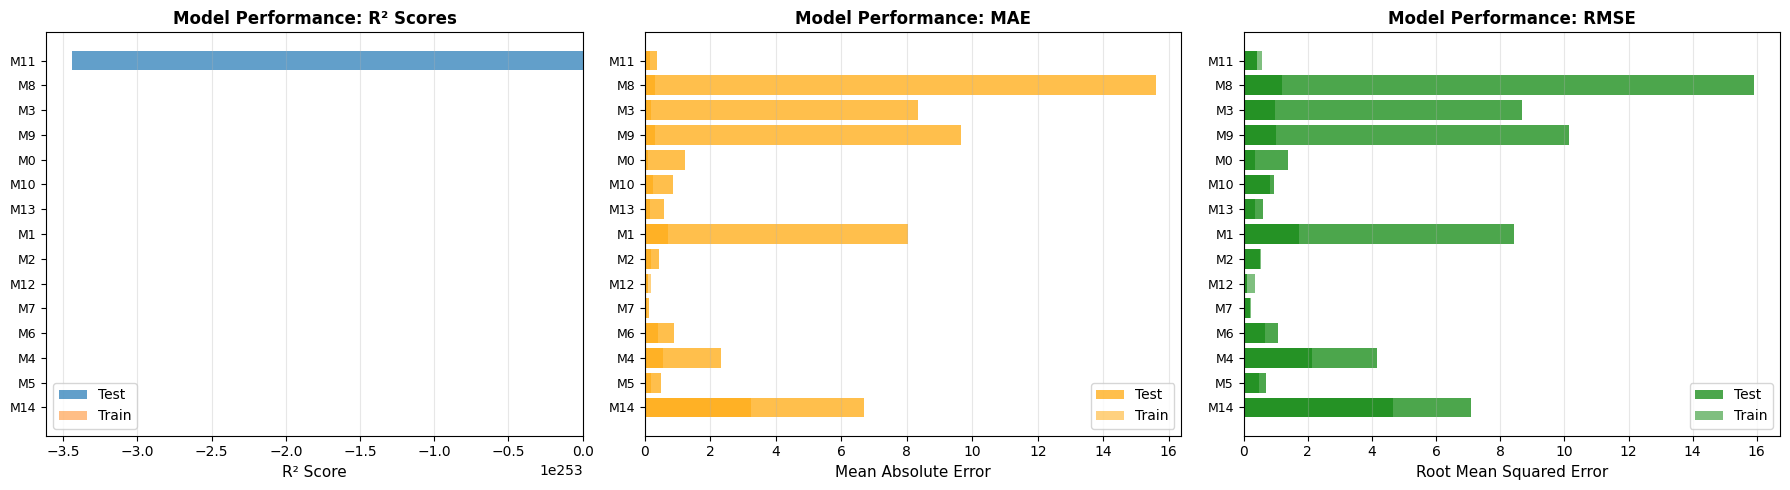

In [28]:
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: R² scores
ax1 = axes[0]
target_names = [t.replace('Stage1.Output.Measurement', 'M').replace('.U.Actual', '') for t in metrics_df['Target']]
ax1.barh(range(len(metrics_df)), metrics_df['Test_R2'].values, alpha=0.7, label='Test')
ax1.barh(range(len(metrics_df)), metrics_df['Train_R2'].values, alpha=0.5, label='Train')
ax1.set_yticks(range(len(metrics_df)))
ax1.set_yticklabels(target_names, fontsize=9)
ax1.set_xlabel('R² Score', fontsize=11)
ax1.set_title('Model Performance: R² Scores', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(0, color='black', linestyle='-', linewidth=0.5)

# Plot 2: MAE
ax2 = axes[1]
ax2.barh(range(len(metrics_df)), metrics_df['Test_MAE'].values, alpha=0.7, color='orange', label='Test')
ax2.barh(range(len(metrics_df)), metrics_df['Train_MAE'].values, alpha=0.5, color='orange', label='Train')
ax2.set_yticks(range(len(metrics_df)))
ax2.set_yticklabels(target_names, fontsize=9)
ax2.set_xlabel('Mean Absolute Error', fontsize=11)
ax2.set_title('Model Performance: MAE', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: RMSE
ax3 = axes[2]
ax3.barh(range(len(metrics_df)), metrics_df['Test_RMSE'].values, alpha=0.7, color='green', label='Test')
ax3.barh(range(len(metrics_df)), metrics_df['Train_RMSE'].values, alpha=0.5, color='green', label='Train')
ax3.set_yticks(range(len(metrics_df)))
ax3.set_yticklabels(target_names, fontsize=9)
ax3.set_xlabel('Root Mean Squared Error', fontsize=11)
ax3.set_title('Model Performance: RMSE', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [31]:
# Check for distribution shift between train and test
print("="*80)
print("DISTRIBUTION SHIFT DIAGNOSIS")
print("="*80)

# Check target distributions
for target_col in target_cols[:3]:  # Check first 3 targets
    train_vals = y_train[target_col].dropna()
    test_vals = y_test[target_col].dropna()
    
    if len(train_vals) > 0 and len(test_vals) > 0:
        print(f"\n{target_col}:")
        print(f"  Train: mean={train_vals.mean():.4f}, std={train_vals.std():.4f}, range=[{train_vals.min():.4f}, {train_vals.max():.4f}]")
        print(f"  Test:  mean={test_vals.mean():.4f}, std={test_vals.std():.4f}, range=[{test_vals.min():.4f}, {test_vals.max():.4f}]")
        
        # Check if means are very different
        mean_diff = abs(train_vals.mean() - test_vals.mean())
        mean_ratio = mean_diff / (train_vals.std() + 1e-6)
        if mean_ratio > 2:
            print(f"    WARNING: Significant mean shift (ratio={mean_ratio:.2f})")

DISTRIBUTION SHIFT DIAGNOSIS

Stage1.Output.Measurement0.U.Actual:
  Train: mean=12.8831, std=1.1159, range=[0.0000, 20.8800]
  Test:  mean=12.9291, std=0.0477, range=[12.5800, 13.0700]

Stage1.Output.Measurement1.U.Actual:
  Train: mean=11.3369, std=5.4577, range=[-3.1328, 19.1400]
  Test:  mean=0.3838, std=2.3265, range=[-0.0034, 18.3000]

Stage1.Output.Measurement2.U.Actual:
  Train: mean=11.3445, std=1.2510, range=[-4.9278, 23.5300]
  Test:  mean=11.3867, std=0.2048, range=[8.9900, 13.3900]


### Key Finding: Distribution Shift

**The test period has fundamentally different characteristics than the training period:**

- **Measurement0**: Test std is **23x smaller** than train (0.048 vs 1.12)
- **Measurement1**: Test mean is **30x different** from train (0.38 vs 11.34)
- **Measurement2**: Test std is **6x smaller** than train (0.20 vs 1.25)

This explains the severe overfitting. The model learns patterns from the training period that don't generalize to the test period because they're operating under different conditions.

**Possible causes:**
- Different product/recipe in test period
- Different raw material properties
- Different process settings/operating regime
- Sensor calibration changes
- Different quality control standards

**Potential solutions:**
1. **Stratified split** - Split by operating regime instead of time
2. **Domain adaptation** - Use techniques to adapt to distribution shift
3. **Separate models** - Train different models for different operating regimes
4. **Feature engineering** - Add features that capture operating regime